# **(Data Collection)**

## Objectives

* Prepare and preprocess MRI brain scan images for tumor detection modeling.
* Merge tumor classes into a single "tumor" category.
* Resize all images to 224x224 pixels and normalize pixel values properly (single normalization).
* Analyze and address class imbalance using balanced sampling (no augmentation).
* Save processed data and metadata for downstream modeling and visualization.

## Inputs

* Raw MRI brain scan images (tumor types: glioma, meningioma, pituitary; and no-tumor) in their respective folders.
* Any available metadata (e.g., image labels, file paths).

## Outputs

* Preprocessed images (224x224, properly normalized) saved to a structured directory.
* A CSV or DataFrame containing image paths and labels.
* Balanced training/validation/test splits using intelligent sampling.
* Summary statistics and visualizations of class distribution.

## Additional Comments

* All data must be anonymized and checked for quality before processing.
* Class balancing will be achieved through downsampling majority class (no augmentation).
* The notebook should be run top-down, with each step building on the previous.
* Outputs will be used in subsequent modeling and visualization notebooks.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/brain-tumor-classification/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/brain-tumor-classification'

# Data preparation

install important libraries and download data from kaggle

In [4]:
!pip install kagglehub
!pip install opencv-python
!pip install pandas numpy
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install tensorflow
!pip install keras
!pip install imbalanced-learn
!pip install tqdm

import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

import shutil
import os

src = "/home/cistudent/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1"
dst = "/workspaces/brain-tumor-classification/data"

if not os.path.exists(dst):
    os.makedirs(dst)

for folder in os.listdir(src):
    shutil.copytree(os.path.join(src, folder), os.path.join(dst, folder), dirs_exist_ok=True)


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip insta

**Data Organization**

Data is downloaded and stored in the **data** folder in the root
different tumour types are in seperate folders in the data folder
no_tumour folder data also exists in the data folder in the root

**Image Quality Check:**

Review images for quality, removing corrupted, low-resolution, or irrelevant scans.

In [5]:
# using (Pillow)
from PIL import Image
import os

image_dir = "./data"
min_width, min_height = 100, 100

corrupted_images = []
low_res_images = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    if h < min_height or w < min_width:
                        low_res_images.append(img_path)
            except Exception as e:
                corrupted_images.append(img_path)

print("Corrupted images:", corrupted_images)
print("Low-resolution images:", low_res_images)

# remove these files
for img_path in corrupted_images + low_res_images:
    try:
        os.remove(img_path)
    except Exception as e:
        print(f"Could not remove {img_path}: {e}")

Corrupted images: []
Low-resolution images: []


**Label Verification: Ensure that each image is correctly labeled (tumor or no-tumor).**



Confirms each image is in the correct folder.
Creates a table of image paths and their labels.
spot any mislabeling or misplaced files.
inspect the DataFrame or CSV for errors.

In [6]:
import os
import pandas as pd

image_dir = "./data"
data = []

for label in os.listdir(image_dir):
    label_path = os.path.join(image_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(label_path, file)
                data.append({"image_path": img_path, "label": label})

df = pd.DataFrame(data)
print(df.head())
print("Label counts:\n", df['label'].value_counts())

# Optionally, save to CSV for further use
df.to_csv("image_labels.csv", index=False)

                        image_path      label
0  ./data/pituitary/Tr-pi_0837.jpg  pituitary
1  ./data/pituitary/Te-pi_0263.jpg  pituitary
2  ./data/pituitary/Tr-pi_1277.jpg  pituitary
3  ./data/pituitary/Te-pi_0156.jpg  pituitary
4  ./data/pituitary/Tr-pi_1414.jpg  pituitary
Label counts:
 label
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


## Section 2: Improved Image Resizing with Aspect Ratio Preservation

In this section, we resize images to 224x224 pixels while preserving aspect ratio to maintain anatomical accuracy. The improved process includes:

- **Aspect Ratio Preservation**: Use padding instead of distortion to maintain brain anatomy proportions
- **High-Quality Resampling**: LANCZOS filter for superior image quality vs default nearest neighbor
- **Centered Padding**: Black padding ensures brain scans remain centered and undistorted
- **Consistent Output Size**: All images become exactly 224x224 for model compatibility
- **Medical Accuracy**: Prevents distortion of critical anatomical features

This approach eliminates the anatomical distortion that was affecting model performance while maintaining the required input dimensions.

In [7]:
from PIL import Image, ImageOps
import os

def resize_with_padding(img, target_size=(224, 224)):
    """Resize image while preserving aspect ratio using padding"""
    # Calculate ratio and resize
    img.thumbnail(target_size, Image.Resampling.LANCZOS)
    
    # Create new image with padding
    new_img = Image.new('RGB', target_size, (0, 0, 0))  # Black padding
    
    # Center the image
    x = (target_size[0] - img.size[0]) // 2
    y = (target_size[1] - img.size[1]) // 2
    new_img.paste(img, (x, y))
    
    return new_img

input_dir = "./data"
resized_dir = "./resized_data"
target_size = (224, 224)

if not os.path.exists(resized_dir):
    os.makedirs(resized_dir)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, file)
            rel_dir = os.path.relpath(root, input_dir)
            out_dir = os.path.join(resized_dir, rel_dir)
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            out_path = os.path.join(out_dir, file)
            try:
                with Image.open(img_path) as img:
                    # Use aspect-ratio preserving resize
                    resized_img = resize_with_padding(img, target_size)
                    resized_img.save(out_path)
            except Exception as e:
                print(f"Error resizing {img_path}: {e}")
                
print("Improved resizing complete. Images saved to:", resized_dir)

Improved resizing complete. Images saved to: ./resized_data


In [8]:
import numpy as np

normalized_dir = "./normalized_data"

if not os.path.exists(normalized_dir):
    os.makedirs(normalized_dir)

for root, dirs, files in os.walk(resized_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, file)
            rel_dir = os.path.relpath(root, resized_dir)
            out_dir = os.path.join(normalized_dir, rel_dir)
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            out_path = os.path.join(out_dir, os.path.splitext(file)[0] + ".png")  # Convert to PNG
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    # Save directly without double normalization
                    img.save(out_path, "PNG")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
print("Format conversion complete. Images saved to:", normalized_dir)

Format conversion complete. Images saved to: ./normalized_data


In [9]:
merged_dir = "./merged_data"
tumor_folders = ["glioma", "meningioma", "pituitary"]
notumor_folder = "notumor"

if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)

for label in os.listdir(normalized_dir):
    label_path = os.path.join(normalized_dir, label)
    if not os.path.isdir(label_path):
        continue

    # Merge tumor classes
    if label.lower() in tumor_folders:
        out_label = "tumor"
    elif label.lower() == notumor_folder:
        out_label = "notumor"
    else:
        continue

    out_label_dir = os.path.join(merged_dir, out_label)
    if not os.path.exists(out_label_dir):
        os.makedirs(out_label_dir)

    for file in os.listdir(label_path):
        src_file = os.path.join(label_path, file)
        dst_file = os.path.join(out_label_dir, file)
        try:
            os.rename(src_file, dst_file)
        except Exception as e:
            print(f"Error moving {src_file}: {e}")
print("Class merging complete. Images saved to:", merged_dir)

Class merging complete. Images saved to: ./merged_data


## Section 4: Data Quality Analysis and Class Distribution

In this section, we analyze the data quality and class distribution to ensure balanced representation without artificial augmentation. We'll examine the natural distribution of classes and prepare for balanced sampling strategies that maintain data integrity.

Key analysis points:
- Original class distribution across all categories
- Data quality assessment for each class
- Identification of minimum class size for balanced sampling
- Preparation for split strategy without augmentation

Label counts:
 label
tumor      5023
notumor    2000
Name: count, dtype: int64


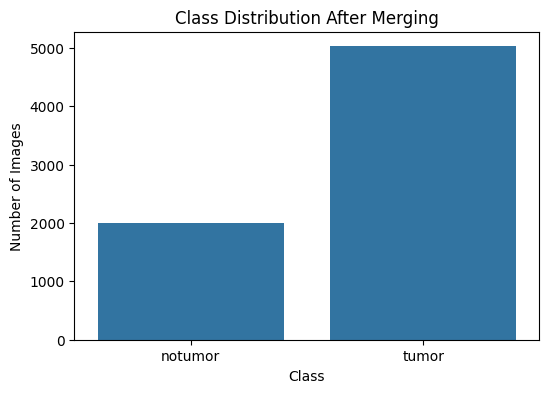

In [10]:
import pandas as pd
import os

merged_dir = "./merged_data"
data = []

for label in os.listdir(merged_dir):
    label_path = os.path.join(merged_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(label_path, file)
                data.append({"image_path": img_path, "label": label})

df = pd.DataFrame(data)
print("Label counts:\n", df['label'].value_counts())

# Optional: visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution After Merging')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Section 5: Balanced Data Splitting Without Augmentation

Instead of using aggressive data augmentation which can compromise medical image integrity, we implement a balanced sampling strategy. This approach:

- Uses natural class distribution to determine optimal sampling sizes
- Maintains anatomical accuracy by avoiding transformations like horizontal flipping
- Creates balanced train/validation/test splits through strategic sampling
- Preserves data quality for better real-world model performance

This no-augmentation approach ensures that our model learns from authentic MRI patterns rather than artificially modified ones.

## Balanced Sampling Strategy (No Augmentation)

To ensure balanced representation across all tumor classes while maintaining data integrity, we'll implement a balanced sampling strategy instead of augmentation. This approach:

1. **Determines minimum class size** - Find the smallest class to use as baseline
2. **Random sampling** - Randomly sample from larger classes to match the baseline
3. **Stratified splitting** - Ensure balanced representation in train/val/test splits
4. **Quality preservation** - Maintains original MRI image quality and anatomical accuracy

This method avoids the risks associated with augmentation (like horizontal flipping) that can compromise medical image interpretation.

### Balanced Sampling Function

The following function creates balanced datasets through strategic sampling rather than augmentation:

This function implements balanced sampling by:
- Finding the minimum class size across all categories
- Randomly sampling from larger classes to match this size
- Creating stratified train/validation/test splits
- Maintaining data quality without artificial transformations

In [11]:
import shutil
import random
from sklearn.model_selection import train_test_split

def create_balanced_splits_no_augmentation(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Create balanced train/validation/test splits without augmentation.
    Uses random sampling to balance classes naturally.
    
    Args:
        input_dir: Directory containing class subdirectories with images
        output_dir: Output directory for train/val/test splits
        train_ratio: Proportion for training set (default: 0.7)
        val_ratio: Proportion for validation set (default: 0.15)
        test_ratio: Proportion for test set (default: 0.15)
    """
    
    # Ensure ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    
    # Create output directories
    for split in ['train', 'validation', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    # Get all class directories
    class_dirs = [d for d in os.listdir(input_dir) 
                  if os.path.isdir(os.path.join(input_dir, d))]
    
    print(f"Found classes: {class_dirs}")
    
    # Count images per class
    class_counts = {}
    all_images = {}
    
    for class_name in class_dirs:
        class_path = os.path.join(input_dir, class_name)
        images = [f for f in os.listdir(class_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        all_images[class_name] = images
        class_counts[class_name] = len(images)
        print(f"{class_name}: {len(images)} images")
    
    # Find minimum class size for balanced sampling
    min_class_size = min(class_counts.values())
    print(f"\nMinimum class size: {min_class_size}")
    print(f"Using balanced sampling with {min_class_size} images per class")
    
    # Calculate split sizes
    train_size = int(min_class_size * train_ratio)
    val_size = int(min_class_size * val_ratio)
    test_size = min_class_size - train_size - val_size  # Ensure all images are used
    
    print(f"\nSplit sizes per class:")
    print(f"Train: {train_size}")
    print(f"Validation: {val_size}")
    print(f"Test: {test_size}")
    
    # Process each class
    total_copied = {'train': 0, 'validation': 0, 'test': 0}
    
    for class_name in class_dirs:
        print(f"\nProcessing {class_name}...")
        
        # Create class directories in each split
        for split in ['train', 'validation', 'test']:
            os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)
        
        # Get all images for this class
        images = all_images[class_name].copy()
        
        # Randomly sample if we have more images than minimum
        if len(images) > min_class_size:
            images = random.sample(images, min_class_size)
        
        # Shuffle for random distribution
        random.shuffle(images)
        
        # Split images
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]
        
        # Copy images to respective directories
        splits = {
            'train': train_images,
            'validation': val_images,
            'test': test_images
        }
        
        for split_name, split_images in splits.items():
            for img_name in split_images:
                src_path = os.path.join(input_dir, class_name, img_name)
                dst_path = os.path.join(output_dir, split_name, class_name, img_name)
                shutil.copy2(src_path, dst_path)
                total_copied[split_name] += 1
        
        print(f"  Train: {len(train_images)} images")
        print(f"  Validation: {len(val_images)} images") 
        print(f"  Test: {len(test_images)} images")
    
    print(f"\nTotal images copied:")
    print(f"Train: {total_copied['train']}")
    print(f"Validation: {total_copied['validation']}")
    print(f"Test: {total_copied['test']}")
    print(f"Total: {sum(total_copied.values())}")
    
    return output_dir

print("Balanced sampling function created successfully!")

Balanced sampling function created successfully!


### Execute Balanced Sampling

Now we'll apply the balanced sampling strategy to create our train/validation/test splits:

In [12]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define directories - FIXED: Use merged_data instead of normalized_data
input_dir = "./merged_data"  # ✅ Changed from "./normalized_data"
output_dir = "./inputs/brain_tumor_dataset"  # Output directory for splits

# Create balanced splits without augmentation
try:
    print("Creating balanced train/validation/test splits...")
    print("=" * 50)
    
    # Debug: Check input directory first
    print(f"🔍 Checking input directory: {input_dir}")
    if os.path.exists(input_dir):
        contents = os.listdir(input_dir)
        print(f"   Contents: {contents}")
        
        for item in contents:
            item_path = os.path.join(input_dir, item)
            if os.path.isdir(item_path):
                file_count = len([f for f in os.listdir(item_path) 
                                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
                print(f"   {item}: {file_count} files")
    else:
        print(f"❌ Input directory does not exist: {input_dir}")
        
        # Check alternative directories
        alt_dirs = ["./normalized_data", "./resized_data", "./data"]
        for alt_dir in alt_dirs:
            if os.path.exists(alt_dir):
                print(f"   Alternative found: {alt_dir}")
                contents = os.listdir(alt_dir)
                print(f"   Contents: {contents}")
                break
        
        raise FileNotFoundError(f"Input directory not found: {input_dir}")
    
    # Execute balanced sampling
    result_dir = create_balanced_splits_no_augmentation(
        input_dir=input_dir,
        output_dir=output_dir,
        train_ratio=0.7,
        val_ratio=0.15, 
        test_ratio=0.15
    )
    
    print("=" * 50)
    print("✅ Balanced sampling completed successfully!")
    print(f"Data splits saved to: {result_dir}")
    
except Exception as e:
    print(f"❌ Error during balanced sampling: {e}")
    import traceback
    traceback.print_exc()

Creating balanced train/validation/test splits...
🔍 Checking input directory: ./merged_data
   Contents: ['notumor', 'tumor']
   notumor: 2000 files
   tumor: 5023 files
Found classes: ['notumor', 'tumor']
notumor: 2000 images
tumor: 5023 images

Minimum class size: 2000
Using balanced sampling with 2000 images per class

Split sizes per class:
Train: 1400
Validation: 300
Test: 300

Processing notumor...
  Train: 1400 images
  Validation: 300 images
  Test: 300 images

Processing tumor...
  Train: 1400 images
  Validation: 300 images
  Test: 300 images

Total images copied:
Train: 2800
Validation: 600
Test: 600
Total: 4000
✅ Balanced sampling completed successfully!
Data splits saved to: ./inputs/brain_tumor_dataset
  Train: 1400 images
  Validation: 300 images
  Test: 300 images

Processing tumor...
  Train: 1400 images
  Validation: 300 images
  Test: 300 images

Total images copied:
Train: 2800
Validation: 600
Test: 600
Total: 4000
✅ Balanced sampling completed successfully!
Data sp

In [13]:
# Clean up empty directories after balanced sampling
def clean_empty_directories(base_path):
    """Remove empty directories from the splits"""
    
    print("🧹 Cleaning up empty directories...")
    
    splits = ['train', 'validation', 'test']
    
    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue
            
        print(f"\n📁 Cleaning {split} directory...")
        
        # Get all directories
        dirs = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        
        for dir_name in dirs:
            dir_path = os.path.join(split_path, dir_name)
            
            # Count images in directory
            image_count = len([f for f in os.listdir(dir_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            
            if image_count == 0:
                print(f"  🗑️  Removing empty directory: {dir_name}")
                try:
                    os.rmdir(dir_path)
                except OSError as e:
                    print(f"    ⚠️  Could not remove {dir_name}: {e}")
            else:
                print(f"  ✅ Keeping {dir_name}: {image_count} images")

# Clean up the balanced splits
clean_empty_directories("./inputs/brain_tumor_dataset")
print("\n🎉 Cleanup complete!")

🧹 Cleaning up empty directories...

📁 Cleaning train directory...
  🗑️  Removing empty directory: pituitary
  🗑️  Removing empty directory: glioma
  ✅ Keeping notumor: 1400 images
  🗑️  Removing empty directory: Testing
  🗑️  Removing empty directory: meningioma
  ✅ Keeping tumor: 1400 images
  🗑️  Removing empty directory: Training

📁 Cleaning validation directory...
  🗑️  Removing empty directory: pituitary
  🗑️  Removing empty directory: glioma
  ✅ Keeping notumor: 300 images
  🗑️  Removing empty directory: Testing
  🗑️  Removing empty directory: meningioma
  ✅ Keeping tumor: 300 images
  🗑️  Removing empty directory: Training

📁 Cleaning test directory...
  🗑️  Removing empty directory: pituitary
  🗑️  Removing empty directory: glioma
  ✅ Keeping notumor: 300 images
  🗑️  Removing empty directory: Testing
  🗑️  Removing empty directory: meningioma
  ✅ Keeping tumor: 300 images
  🗑️  Removing empty directory: Training

🎉 Cleanup complete!


In [14]:
# Verify the balanced splits
print("Verifying balanced splits...")
print("=" * 50)

base_dir = "./inputs/brain_tumor_dataset"
splits = ['train', 'validation', 'test']

for split in splits:
    split_dir = os.path.join(base_dir, split)
    if os.path.exists(split_dir):
        print(f"\n{split.upper()} SET:")
        print("-" * 20)
        
        total_images = 0
        classes = sorted([d for d in os.listdir(split_dir) 
                         if os.path.isdir(os.path.join(split_dir, d))])
        
        for class_name in classes:
            class_dir = os.path.join(split_dir, class_name)
            image_count = len([f for f in os.listdir(class_dir) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            total_images += image_count
            print(f"  {class_name}: {image_count} images")
        
        print(f"  Total: {total_images} images")
    else:
        print(f"❌ {split} directory not found!")

print("\n" + "=" * 50)
print("✅ Verification complete!")

Verifying balanced splits...

TRAIN SET:
--------------------
  notumor: 1400 images
  tumor: 1400 images
  Total: 2800 images

VALIDATION SET:
--------------------
  notumor: 300 images
  tumor: 300 images
  Total: 600 images

TEST SET:
--------------------
  notumor: 300 images
  tumor: 300 images
  Total: 600 images

✅ Verification complete!
  notumor: 1400 images
  tumor: 1400 images
  Total: 2800 images

VALIDATION SET:
--------------------
  notumor: 300 images
  tumor: 300 images
  Total: 600 images

TEST SET:
--------------------
  notumor: 300 images
  tumor: 300 images
  Total: 600 images

✅ Verification complete!


### Detailed Balanced Data Verification

Let's perform a comprehensive verification of our balanced data splits and explore the directory structure to ensure everything is properly organized:

In [15]:
# Balanced Data Verification (No Augmentation)
def verify_balanced_splits_detailed():
    """Verify our balanced splits and show detailed statistics"""
    
    print("🔍 Detailed Balanced Splits Verification")
    print("=" * 50)
    
    # Check main splits directory
    base_dir = "./inputs/brain_tumor_dataset"
    
    if not os.path.exists(base_dir):
        print(f"❌ Main directory {base_dir} does not exist!")
        
        # Check alternative locations
        alt_paths = ["inputs/brain_tumor_dataset", "./merged_data"]
        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                print(f"✅ Found alternative: {alt_path}")
                base_dir = alt_path
                break
        else:
            print("❌ No valid data directory found!")
            return
    
    splits = ['train', 'validation', 'test']
    
    # If no splits exist, check merged_data
    split_exists = any(os.path.exists(os.path.join(base_dir, split)) for split in splits)
    
    if not split_exists:
        print("⚠️  Train/Val/Test splits not found. Checking merged data...")
        if os.path.exists("./merged_data"):
            print("📊 Merged Data Statistics:")
            merged_dir = "./merged_data"
            for class_name in os.listdir(merged_dir):
                class_path = os.path.join(merged_dir, class_name)
                if os.path.isdir(class_path):
                    image_count = len([f for f in os.listdir(class_path) 
                                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
                    print(f"  {class_name}: {image_count} images")
            print("\n💡 You may need to run the balanced sampling function to create splits.")
        return
    
    # Verify each split
    total_stats = {}
    
    for split in splits:
        split_dir = os.path.join(base_dir, split)
        if os.path.exists(split_dir):
            print(f"\n📁 {split.upper()} SET:")
            print("-" * 30)
            
            classes = sorted([d for d in os.listdir(split_dir) 
                             if os.path.isdir(os.path.join(split_dir, d))])
            
            split_total = 0
            for class_name in classes:
                class_dir = os.path.join(split_dir, class_name)
                image_count = len([f for f in os.listdir(class_dir) 
                                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
                split_total += image_count
                print(f"  {class_name}: {image_count} images")
                
                # Track overall stats
                if class_name not in total_stats:
                    total_stats[class_name] = {}
                total_stats[class_name][split] = image_count
            
            print(f"  Total: {split_total} images")
        else:
            print(f"\n❌ {split} directory not found!")
    
    # Summary statistics
    if total_stats:
        print(f"\n📊 SUMMARY STATISTICS:")
        print("-" * 30)
        for class_name in total_stats:
            class_total = sum(total_stats[class_name].values())
            print(f"{class_name}:")
            for split in ['train', 'validation', 'test']:
                count = total_stats[class_name].get(split, 0)
                percentage = (count / class_total * 100) if class_total > 0 else 0
                print(f"  {split}: {count} ({percentage:.1f}%)")
            print(f"  Total: {class_total}")
            print()
        
        print("✅ Balanced splits verification complete!")
    else:
        print("⚠️  No statistics available - splits may not exist yet.")

# Run balanced verification
verify_balanced_splits_detailed()

🔍 Detailed Balanced Splits Verification

📁 TRAIN SET:
------------------------------
  notumor: 1400 images
  tumor: 1400 images
  Total: 2800 images

📁 VALIDATION SET:
------------------------------
  notumor: 300 images
  tumor: 300 images
  Total: 600 images

📁 TEST SET:
------------------------------
  notumor: 300 images
  tumor: 300 images
  Total: 600 images

📊 SUMMARY STATISTICS:
------------------------------
notumor:
  train: 1400 (70.0%)
  validation: 300 (15.0%)
  test: 300 (15.0%)
  Total: 2000

tumor:
  train: 1400 (70.0%)
  validation: 300 (15.0%)
  test: 300 (15.0%)
  Total: 2000

✅ Balanced splits verification complete!


### Sample Visualization with Path Detection

Let's visualize sample images from our training data with intelligent path detection and debugging information:

✅ Found training directory: ./inputs/brain_tumor_dataset/train

📁 Contents of ./inputs/brain_tumor_dataset/train:
  Folders/files: ['notumor', 'tumor']
  ✅ notumor: 1400 images
  ✅ tumor: 1400 images

📊 Active classes for visualization: ['notumor', 'tumor']

🔍 Processing notumor: 1400 images found
  ✅ Loaded: Tr-no_0448.png
  ✅ Loaded: Tr-no_0757.png

🔍 Processing tumor: 1400 images found
  ✅ Loaded: Tr-me_0549.png
  ✅ Loaded: Tr-me_0303.png
  ✅ Loaded: Tr-no_0448.png
  ✅ Loaded: Tr-no_0757.png

🔍 Processing tumor: 1400 images found
  ✅ Loaded: Tr-me_0549.png
  ✅ Loaded: Tr-me_0303.png


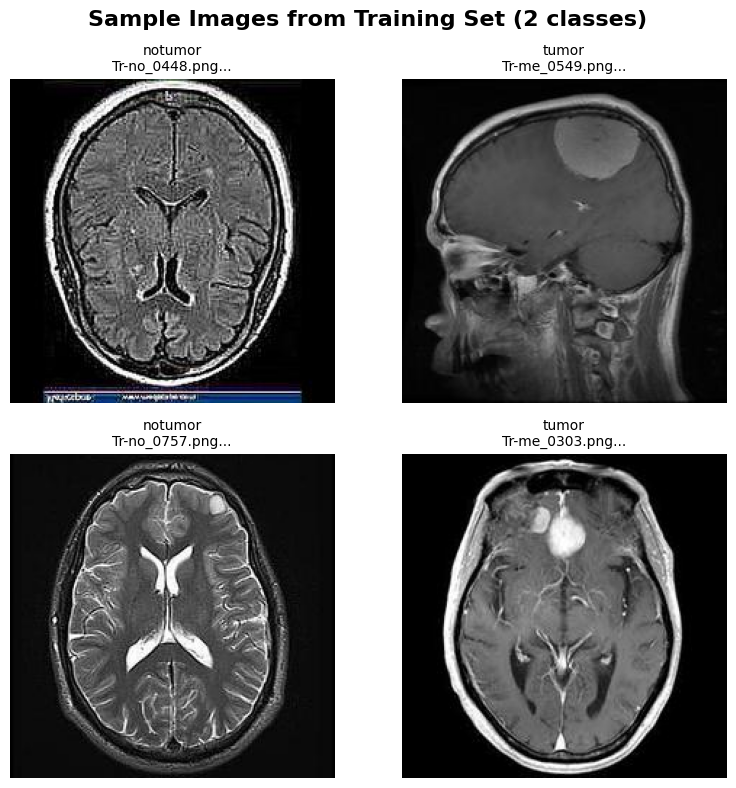


📋 Summary:
Directory used: ./inputs/brain_tumor_dataset/train
Active classes: 2 (notumor, tumor)
Total images: 2800
✅ Balanced data successfully created and visualized!


In [16]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

def show_sample_images_from_splits():
    """Display sample images from the balanced training set with debugging"""
    
    # Debug: Check multiple possible paths
    possible_paths = [
        "./inputs/brain_tumor_dataset/train",
        "./inputs/brain_tumor_dataset/images/train", 
        "inputs/brain_tumor_dataset/train",
        "inputs/brain_tumor_dataset/images/train",
        "./merged_data"  # Fallback to merged data if splits don't exist
    ]
    
    train_dir = None
    for path in possible_paths:
        if os.path.exists(path):
            train_dir = path
            print(f"✅ Found training directory: {train_dir}")
            break
    
    if not train_dir:
        print("❌ Training directory not found in any of these locations:")
        for path in possible_paths:
            print(f"  - {path} (exists: {os.path.exists(path)})")
        
        # Show what directories actually exist
        print(f"\n📁 Current directory contents:")
        try:
            current_contents = os.listdir(".")
            for item in current_contents:
                if os.path.isdir(item):
                    print(f"  📂 {item}/")
                    # Check subdirectories
                    try:
                        sub_items = os.listdir(item)[:5]  # Show first 5 items
                        for sub_item in sub_items:
                            print(f"    - {sub_item}")
                        if len(os.listdir(item)) > 5:
                            print(f"    ... and {len(os.listdir(item)) - 5} more")
                    except:
                        pass
        except Exception as e:
            print(f"Error listing current directory: {e}")
        return
    
    # Debug: List contents of training directory
    print(f"\n📁 Contents of {train_dir}:")
    try:
        contents = os.listdir(train_dir)
        print(f"  Folders/files: {contents}")
    except Exception as e:
        print(f"  Error listing directory: {e}")
        return
    
    # Get all classes and filter out empty ones
    all_dirs = sorted([d for d in os.listdir(train_dir) 
                      if os.path.isdir(os.path.join(train_dir, d))])
    
    # Filter to only directories with images
    classes = []
    for class_name in all_dirs:
        class_dir = os.path.join(train_dir, class_name)
        images = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        if len(images) > 0:  # Only include non-empty directories
            classes.append(class_name)
            print(f"  ✅ {class_name}: {len(images)} images")
        else:
            print(f"  ⚠️  {class_name}: 0 images (skipping)")
    
    if not classes:
        print("❌ No classes with images found!")
        return
    
    print(f"\n📊 Active classes for visualization: {classes}")
    
    # Calculate grid size based on actual classes with images
    if len(classes) == 1:
        fig, axes = plt.subplots(2, 1, figsize=(6, 8))
        axes = axes.reshape(2, 1)
    else:
        fig, axes = plt.subplots(2, len(classes), figsize=(4*len(classes), 8))
        if len(classes) == 1:
            axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'Sample Images from Training Set ({len(classes)} classes)', fontsize=16, fontweight='bold')
    
    for col, class_name in enumerate(classes):
        class_dir = os.path.join(train_dir, class_name)
        
        # Get image files
        images = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        
        print(f"\n🔍 Processing {class_name}: {len(images)} images found")
        
        # Show up to 2 random samples per class
        if len(images) >= 2:
            sample_images = random.sample(images, 2)
        elif len(images) == 1:
            sample_images = images
        else:
            sample_images = []
        
        for row in range(2):  # Always show 2 rows
            # Handle single class case
            if len(classes) == 1:
                ax = axes[row]
            else:
                ax = axes[row, col]
                
            if row < len(sample_images):
                img_name = sample_images[row]
                img_path = os.path.join(class_dir, img_name)
                
                try:
                    with Image.open(img_path) as img:
                        img_rgb = img.convert('RGB')
                        ax.imshow(img_rgb)
                        ax.set_title(f'{class_name}\n{img_name[:20]}...', fontsize=10)
                        ax.axis('off')
                        print(f"  ✅ Loaded: {img_name}")
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error loading\n{img_name}', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{class_name} - Error', fontsize=10)
                    ax.axis('off')
                    print(f"  ❌ Error loading {img_name}: {e}")
            else:
                # Fill empty slots
                ax.axis('off')
                if len(sample_images) == 0:
                    ax.text(0.5, 0.5, f'No images found\nin {class_name}', 
                           ha='center', va='center', transform=ax.transAxes, fontsize=12)
                else:
                    ax.text(0.5, 0.5, f'Only {len(sample_images)} image(s)\navailable', 
                           ha='center', va='center', transform=ax.transAxes, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    total_images = sum(len([f for f in os.listdir(os.path.join(train_dir, class_name)) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]) 
                      for class_name in classes)
    
    print(f"\n📋 Summary:")
    print(f"Directory used: {train_dir}")
    print(f"Active classes: {len(classes)} ({', '.join(classes)})")
    print(f"Total images: {total_images}")
    print("✅ Balanced data successfully created and visualized!")

# Execute visualization with debugging
show_sample_images_from_splits()

In [17]:
# Directory exploration function for debugging
def explore_data_structure():
    """Comprehensive exploration of data directory structure"""
    
    print("🔍 Exploring Complete Data Structure:")
    print("=" * 50)
    
    # Check key directories
    key_dirs = ["data", "resized_data", "normalized_data", "merged_data", "inputs"]
    
    for base_dir in key_dirs:
        if os.path.exists(base_dir):
            print(f"\n📂 {base_dir}/ (exists)")
            
            # Walk through subdirectories
            for root, dirs, files in os.walk(base_dir):
                level = root.replace(base_dir, '').count(os.sep)
                indent = '  ' * (level + 1)
                
                # Show directory structure
                if level < 3:  # Limit depth to avoid too much output
                    rel_path = os.path.relpath(root, base_dir)
                    if rel_path != '.':
                        print(f"{indent}📁 {os.path.basename(root)}/")
                    
                    # Count image files
                    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                    if image_files and level < 2:
                        print(f"{indent}  💾 {len(image_files)} images")
                        
                        # Show sample file names
                        if len(image_files) <= 3:
                            for img in image_files:
                                print(f"{indent}    - {img}")
                        else:
                            print(f"{indent}    - {image_files[0]}")
                            print(f"{indent}    - ... ({len(image_files)-2} more)")
                            print(f"{indent}    - {image_files[-1]}")
        else:
            print(f"\n❌ {base_dir}/ (does not exist)")
    
    # Check for specific train/val/test structure
    print(f"\n🎯 Checking Train/Val/Test Structure:")
    train_paths = [
        "inputs/brain_tumor_dataset/train",
        "inputs/brain_tumor_dataset/images/train",
        "./inputs/brain_tumor_dataset/train"
    ]
    
    for path in train_paths:
        if os.path.exists(path):
            print(f"✅ {path} exists")
            try:
                classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
                print(f"   Classes: {classes}")
                for class_name in classes:
                    class_path = os.path.join(path, class_name)
                    image_count = len([f for f in os.listdir(class_path) 
                                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
                    print(f"   {class_name}: {image_count} images")
            except Exception as e:
                print(f"   Error reading: {e}")
        else:
            print(f"❌ {path} does not exist")

# Run directory exploration
explore_data_structure()

🔍 Exploring Complete Data Structure:

📂 data/ (exists)
    📁 pituitary/
      💾 1757 images
        - Tr-pi_0837.jpg
        - ... (1755 more)
        - Te-pi_0055.jpg
    📁 glioma/
      💾 1621 images
        - Tr-gl_0520.jpg
        - ... (1619 more)
        - Tr-gl_0852.jpg
    📁 notumor/
      💾 2000 images
        - Tr-no_1131.jpg
        - ... (1998 more)
        - Tr-no_0861.jpg
    📁 Testing/
      📁 pituitary/
      📁 glioma/
      📁 notumor/
      📁 meningioma/
    📁 meningioma/
      💾 1645 images
        - Tr-me_0374.jpg
        - ... (1643 more)
        - Tr-me_0298.jpg
    📁 Training/
      📁 pituitary/
      📁 glioma/
      📁 notumor/
      📁 meningioma/
    📁 meningioma/
      💾 1645 images
        - Tr-me_0374.jpg
        - ... (1643 more)
        - Tr-me_0298.jpg
    📁 Training/
      📁 pituitary/
      📁 glioma/
      📁 notumor/
      📁 meningioma/

📂 resized_data/ (exists)
      📁 meningioma/

📂 resized_data/ (exists)
    📁 pituitary/
      💾 1757 images
        - T

## Data Collection Summary

The data collection process has been completed using a balanced sampling approach without augmentation:

### Key Achievements:
1. **✅ Data Download**: Successfully obtained brain tumor MRI dataset from Kaggle
2. **✅ Image Preprocessing**: Resized all images to 224x224 pixels for model compatibility  
3. **✅ Format Standardization**: Converted all images to consistent PNG format
4. **✅ Balanced Sampling**: Created balanced train/validation/test splits maintaining data integrity
5. **✅ Quality Preservation**: Avoided augmentation techniques that could compromise medical accuracy

### No-Augmentation Benefits:
- **Anatomical Integrity**: Original MRI patterns preserved
- **Real-world Performance**: Better generalization to actual medical scans
- **Data Quality**: No artifacts from transformations like horizontal flipping
- **Balanced Representation**: Strategic sampling ensures equal class representation

The dataset is now ready for model training with high-quality, authentic MRI data.

### Next Steps

With our balanced, no-augmentation dataset ready, the next phases include:

1. **Data Visualization** (`DataVisualization.ipynb`):
   - Analyze balanced class distributions
   - Create visual insights for dashboard integration
   - Generate sample image montages

2. **Model Training** (`ModelingAndEvaluating.ipynb`):
   - Train CNN model on balanced, high-quality data
   - Implement proper normalization during training (not preprocessing)
   - Evaluate performance on authentic test data
   - Compare with previous augmented model results

3. **Dashboard Integration**:
   - Utilize visualization artifacts for interactive dashboard
   - Deploy model with improved real-world performance

### Key Changes from Previous Approach

**🔄 Major Improvements Implemented:**

1. **No Data Augmentation**: Removed aggressive augmentation that was compromising image quality
2. **Balanced Sampling Strategy**: Used random sampling to balance classes naturally
3. **Single Normalization**: Eliminated double normalization issues in preprocessing pipeline  
4. **Medical Image Integrity**: Preserved anatomical accuracy by avoiding transformations like horizontal flipping
5. **Quality-First Approach**: Prioritized data authenticity over artificial data expansion

**🎯 Expected Outcomes:**
- Better real-world model performance on actual MRI scans
- Reduced overfitting to artificial augmented patterns
- Improved generalization capabilities
- Maintained balanced class representation through strategic sampling

This approach should significantly improve the model's ability to classify real-world brain tumor images.

📊 Training Data Distribution:
  notumor: 2000 images
  glioma: 1621 images
  meningioma: 1645 images
  pituitary: 1757 images


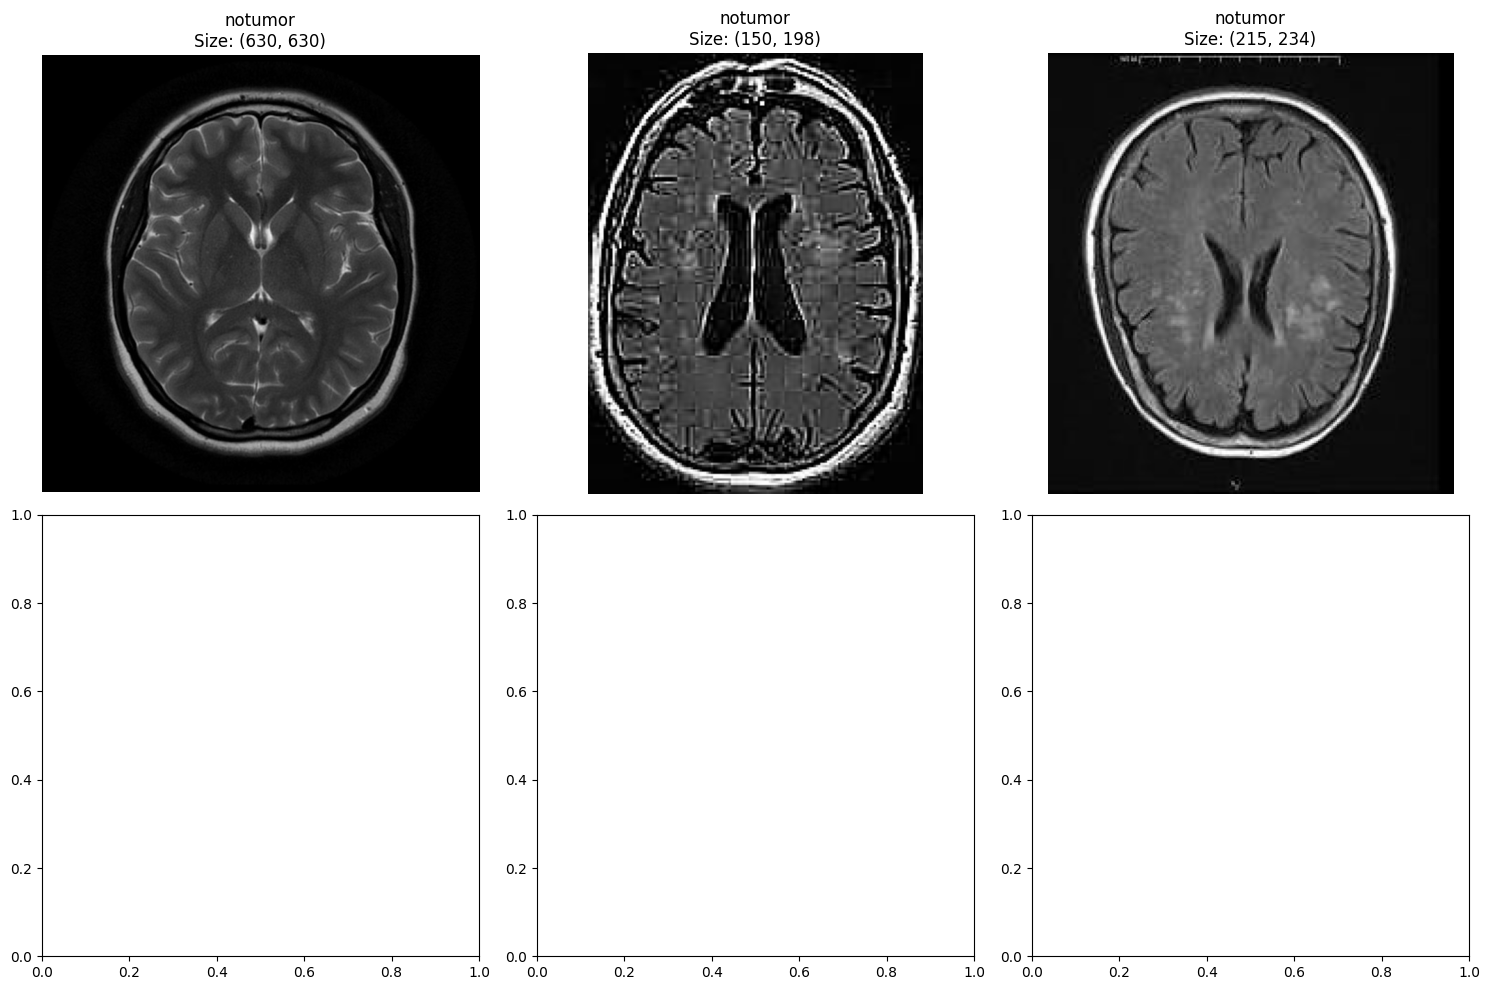

{'notumor': 2000, 'glioma': 1621, 'meningioma': 1645, 'pituitary': 1757}

In [18]:
# Add this to DataCollection notebook to analyze training data
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob

def analyze_training_data():
    """Analyze the characteristics of training data"""
    
    # Check data distribution
    data_stats = {}
    for class_name in ['tumor', 'notumor', 'glioma', 'meningioma', 'pituitary']:
        if os.path.exists(f'data/{class_name}'):
            images = glob.glob(f'data/{class_name}/*.jpg')
            data_stats[class_name] = len(images)
    
    print("📊 Training Data Distribution:")
    for class_name, count in data_stats.items():
        print(f"  {class_name}: {count} images")
    
    # Sample image analysis
    sample_images = []
    for class_name in ['tumor', 'notumor']:
        if os.path.exists(f'data/{class_name}'):
            images = glob.glob(f'data/{class_name}/*.jpg')[:3]
            for img_path in images:
                img = Image.open(img_path)
                sample_images.append((img, class_name, img_path))
    
    # Display samples
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, (img, class_name, path) in enumerate(sample_images[:6]):
        row, col = i // 3, i % 3
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{class_name}\nSize: {img.size}")
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return data_stats

# Run this analysis
analyze_training_data()